In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, RocCurveDisplay

from xgboost import XGBClassifier
import xgboost as xgb_module
import shap

pd.set_option("display.max_columns", 150)
pd.set_option("display.width", 180)

In [2]:
df = pd.read_csv("sydney_traffic_incidents_clean.csv")
print("Shape:", df.shape)
df.head()

Shape: (82624, 84)


,Main_Category,Longitude,Latitude,Day,duration,Primary_Vehicle,Secondary_Vehicle,Is_Major_Incident,Advice_A,Advice_B,Closure_Type,Direction,Main_Street,Affected_Lanes,Actual_Number_of_Lanes,Suburb,Traffic_Volume,SA2_CODE21,SA3_NAME21,AREASQKM21,2_ML,3_TRL,4_PRL,5_SRL,6_TrRL,7_RRL,8_LsRL,9_URL,10_ToRL,11_EoR,12_NoN,13_NDEs,14_NNC2L,15_NNC3L,16_NNC4L,17_AND,18_NE,19_MCI,20_CoI,21 NBS,22_CA,23_EA,24_HA,25_IA,26_OA,27_PA,28_PrA,29_RA,30_TA,31_WbA,32_EoLU,33_TP,34_PD0MV,35_PD1MV,36_PD2MV,37_PD3MV,38_PD≥4MV,39_PUE,40_AMI,41_NPTtWbyPT,42_NPTtWbyTx,43_NPTtWbyCD,44_NPTtWbyCP,45_NPTtWbyO,46_NPWfH,47_PWCJH,48_PBCJH,49_ANP_FH,RMS,Motorway Crew,Mechanic,Emergency service(s),Tow Truck,Motorway crew,Emergency services,Transport for NSW,Tow truck,Heavy vehicle tow truck,Incident_Type,Num_Vehicles_Involved,Month,Hour,distance_to_CBD,duration_class
0,1,151.058,-33.9431,5,39.319950,1,2,0,10,0,0,3,1680,99,99,841,3,119021366,11,5.2458,7.488104,3.038780,2.236683,6.602571,2.551265,42.103090,0.0,0.115587,64.136080,0.504771,325,40,7,260,17,2.790769,491,0.258915,0.001351,210,0.0938,0.1211,0.0000,0.7056,0.0,0.5171,0.0,3.8082,0.0000,0.0,0.386385,21537,11.297837,37.886855,30.565724,12.296173,7.953411,12.109393,831,342,16,2806,276,260,1520,67.634460,32.365540,3.713468,0,0,0,0,0,0,1,0,0,0,0,2,8,19,15.781064,1
1,0,151.159,-33.8096,6,12.029000,1,9,0,10,134,2,8,1343,1,2,535,3,121011399,13,5.5372,8.365015,2.097842,7.903368,4.617769,0.232704,40.351141,0.0,0.739679,64.307518,0.515889,269,59,6,176,28,2.643123,383,0.215760,0.001839,210,0.0080,0.1223,0.0238,0.0000,0.0,1.3725,0.0,4.0106,0.0000,0.0,0.302463,21270,10.253288,52.715538,29.067219,5.723332,2.240623,7.776211,1643,651,6,2652,227,514,6070,88.007396,11.992604,3.023239,0,1,0,0,0,0,0,0,0,0,1,1,8,0,8.323913,0
2,1,150.875,-33.7344,6,16.956667,1,9,0,26,134,2,8,2845,1,1,810,3,116011304,3,7.3828,9.051683,0.000000,12.307502,5.297219,9.525819,56.104489,0.0,0.128916,92.415628,0.523895,468,112,2,307,47,2.617521,631,0.176155,0.001177,234,0.0000,0.2768,0.0000,0.3180,0.0,0.9027,0.0,5.6929,0.1924,0.0,0.352217,20570,8.724832,41.000610,34.716290,10.600976,4.957291,9.688867,1030,532,18,3686,323,256,2398,67.554766,32.445234,3.341706,0,1,0,0,0,0,1,0,0,0,0,1,8,1,34.354983,0
3,1,150.973,-33.8172,6,42.804117,5,2,0,10,0,0,8,1537,1,1,901,2,125041589,31,3.9355,9.698544,8.941532,0.016410,1.416884,5.140331,32.486126,0.0,0.512046,58.211873,0.547443,266,39,7,188,31,2.804511,402,0.259962,0.001650,174,0.1010,0.1006,0.0236,0.0000,0.0,0.2426,0.0,3.1727,0.2950,0.0,0.329226,21564,13.219616,56.830135,22.857143,4.804549,2.288557,9.956409,1302,902,11,2707,291,311,4379,78.956666,21.043334,3.248887,0,0,0,0,0,0,1,1,0,0,0,1,8,1,22.500677,1
4,1,150.981,-33.7919,6,40.840000,3,4,0,10,134,0,7,2059,99,99,742,3,125041493,31,7.4795,0.000000,9.092391,0.000000,7.092430,13.338771,51.982067,0.0,4.266734,85.772393,0.515169,454,105,3,322,23,2.585903,598,0.160576,0.001272,194,0.4036,0.1788,0.0000,0.0000,0.0,0.8217,0.0,6.0754,0.0000,0.0,0.285901,22840,8.134605,39.745628,35.466349,10.996290,5.657128,9.071804,1170,589,18,3487,314,261,3798,77.384802,22.615198,3.295874,0,0,0,0,1,0,0,0,0,0,0,3,8,1,22.753003,1


In [3]:
# target duration_class
y = df["duration_class"]

# XGBoost handles high cardinality values well, so we can use the full dataset!
X = df.drop(columns=["duration", "duration_class"])

# split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

X_train.shape, X_test.shape


((66099, 82), (16525, 82))

In [4]:
# build the model, basically default values
xgb = XGBClassifier(
    n_estimators=300,
    learning_rate=0.1,
    max_depth=8,
    subsample=0.9,
    colsample_bytree=0.9,
    objective="binary:logistic",
    eval_metric="logloss",
    n_jobs=-1,
    random_state=42
)

start_time = time.time()
xgb.fit(X_train, y_train)
end_time = time.time()

print(f"Training time: {end_time - start_time:.2f} seconds")


Training time: 2.01 seconds


In [5]:
# check out predictions and metrics
y_pred = xgb.predict(X_test)
y_proba = xgb.predict_proba(X_test)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))


Accuracy: 0.6631164901664145
Precision: 0.6575560567865198
Recall: 0.6240241752707126
F1 Score: 0.6403514438917243
ROC-AUC: 0.7273619210556976


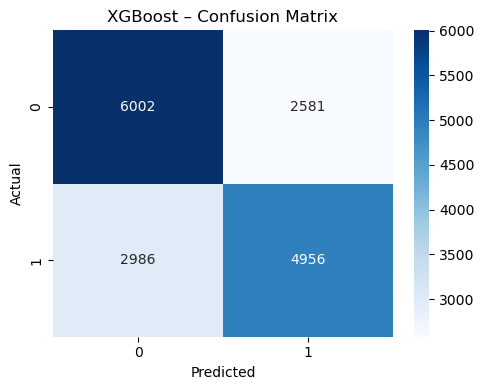

In [6]:
# and the confustion matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("XGBoost – Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


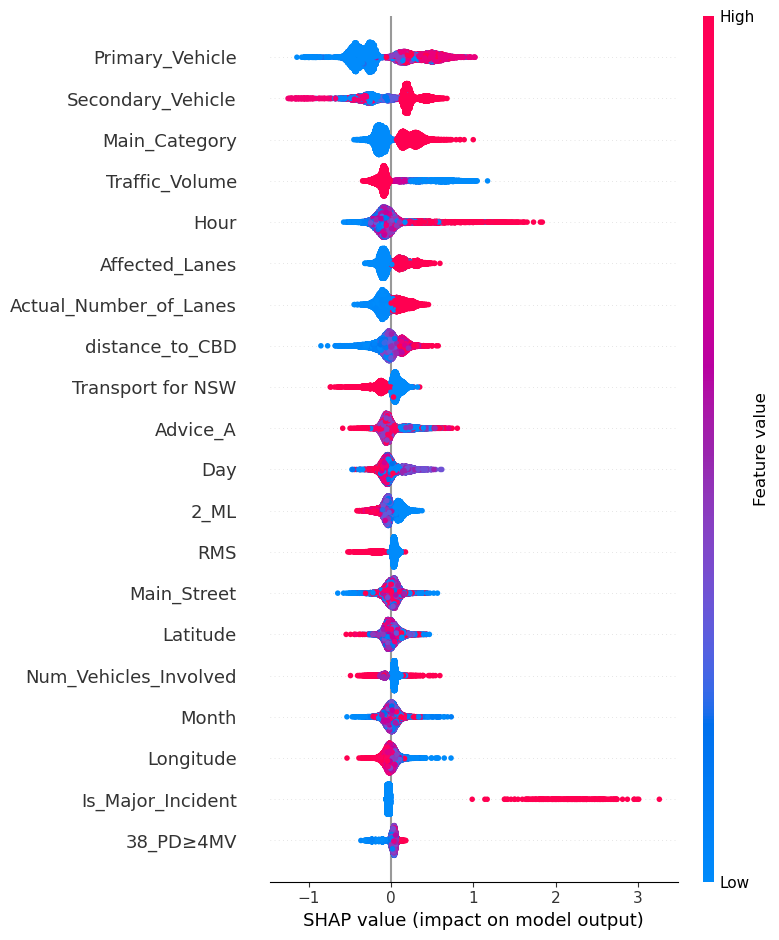

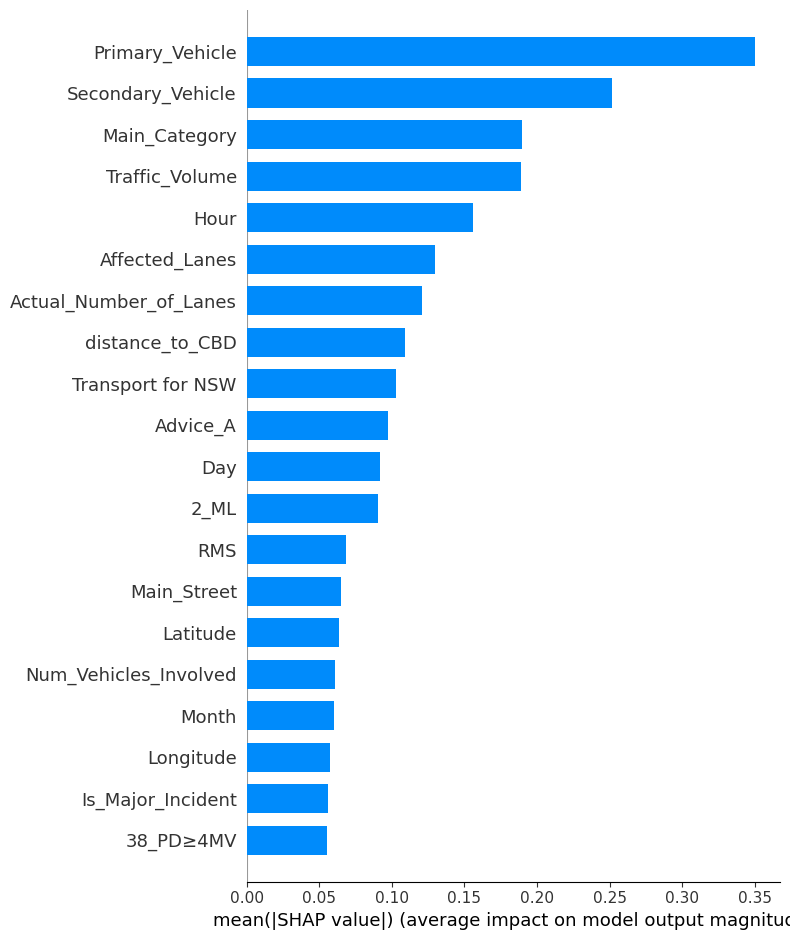

In [7]:
# now to look at feature importance with SHAP
shap.initjs()

dmatrix_test = xgb_module.DMatrix(X_test, feature_names=X_test.columns.tolist())

# booster from the trained model allows us to retrieve SHAP values
booster = xgb.get_booster()

shap_values = booster.predict(dmatrix_test, pred_contribs=True)

# remove the last column whihc contains a bias term
shap_values = shap_values[:, :-1]

# plot the results
shap.summary_plot(shap_values, X_test, max_display=20)
shap.summary_plot(shap_values, X_test, plot_type="bar", max_display=20)